In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.3
    Uninstalling pip-22.0.3:
      Successfully uninstalled pip-22.0.3
utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


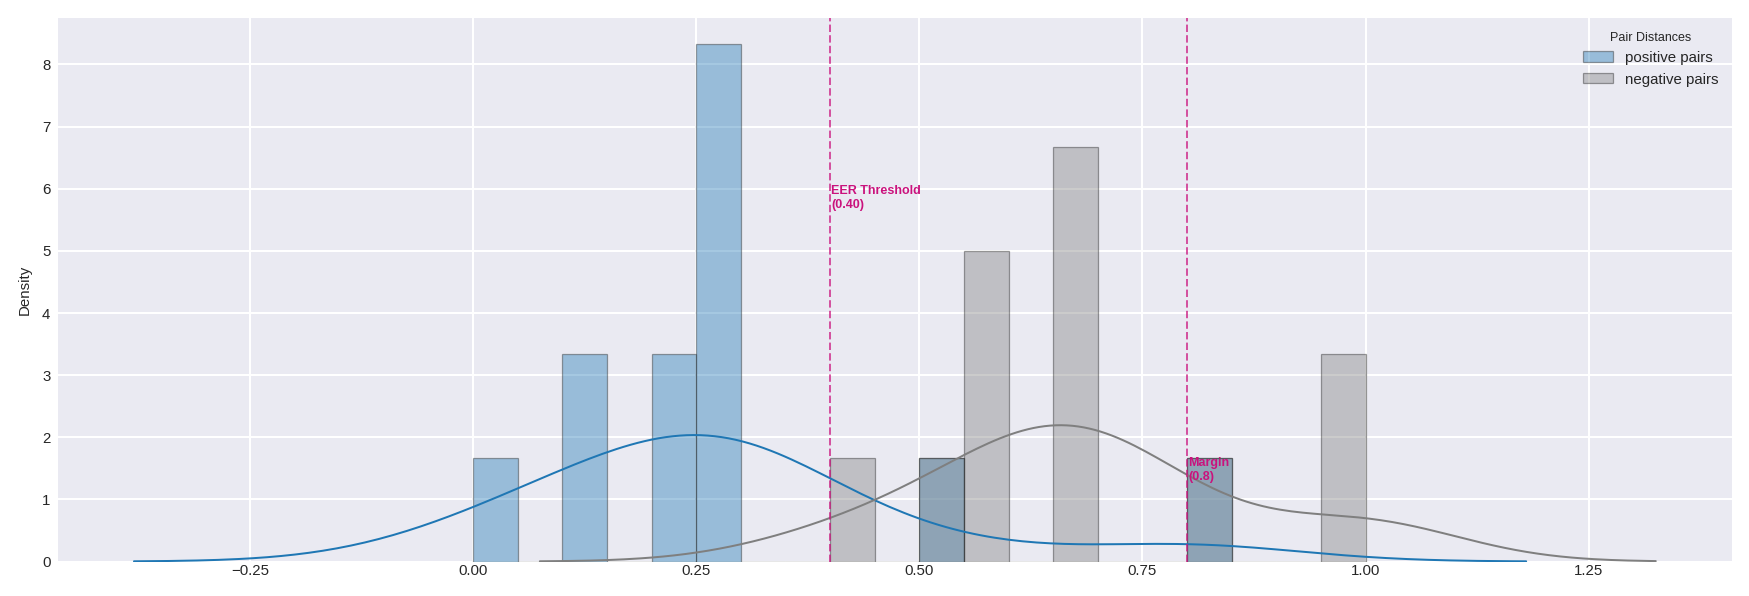

utility functions imported
Seed was set to: 567
Setup Complete


In [2]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy


from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as keras_concat
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping




import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# jupyter nbconvert --to script 'my-notebook.ipynb'
%run ./utility-functions.ipynb
# %run ./utility-functions.py


np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seed was set to: {SEED}")


print("Setup Complete")

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
#     exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    nn_step_width: int
    ocsvm_step_width: int

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
#     # Data / Splitting
    frequency=100,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z"
    ],
    max_subjects=29,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=100 * 1,  #1 sec
    nn_step_width=125,
    ocsvm_step_width=125,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
#     filters=[32, 64, 128, 64],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_kernel="rbf",
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST_125 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=125,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_1500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_2000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=2000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

In [4]:
P = VALID_FCN_ROBUST_1000
# utils_ppp(P)
# P = VALID_ROBUST_1D
# utils_ppp(P)
# P = NAIVE_MINMAX_2D

P.nn_step_width = int(P.window_size * .5)
P.ocsvm_step_width = int(P.window_size * .5)
P.scaler = 'RobustScaler'
# P.scaler = 'MinMaxScaler'
# P.scaler = 'Normalizer'
# P.scaler = 'StandardScaler'

utils_ppp(P)

df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

# P.smoothing = "FFT"
# P.cut_off_freq=25
# ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
# raw_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
# ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1 = ffted_dfList_exp1
# dfList_exp2 = ffted_dfList_exp2

# P.span=49
# P.smoothing = "FFT+EMA"
# # raw_dfList_exp1 = dfList_exp1
# # raw_dfList_exp2 = dfList_exp2
# P.cut_off_freq=42
# ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
# EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
# EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
# EMAed_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1 = EMAed_dfList_exp1
# dfList_exp2 = EMAed_dfList_exp2

num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

# ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1_user_47 = ffted_dfList_exp1_user_47
# dfList_exp2_user_47 = ffted_dfList_exp2_user_47


# EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
# EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
# EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
# dfList_exp2_user_47 = EMAed_dfList_exp2_user_47


randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

,Value
name,VALID-FCN-ROBUST-FINAL
frequency,100
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z]"
max_subjects,29
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
n_valid_train_subjects,40
n_valid_test_subjects,10


Loading exp1 data:


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 28388, gyro_count: 31997


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 26010, gyro_count: 28954


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 24228, gyro_count: 24208


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22631, gyro_count: 23835


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 24473, gyro_count: 23749
45) accel_count: 23974, gyro_count: 23229


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 23614, gyro_count: 23827
48) accel_count: 22828, gyro_count: 23904


/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:
1) accel_count: 24049, gyro_count: 26943


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 24468, gyro_count: 27667
3) accel_count: 24611, gyro_count: 27000


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24972, gyro_count: 26798
5) accel_count: 23573, gyro_count: 23372


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 23800, gyro_count: 23890
7) accel_count: 23347, gyro_count: 24145


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 22947, gyro_count: 22660
19) accel_count: 26156, gyro_count: 25815
21) accel_count: 23566, gyro_count: 24408


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 23844, gyro_count: 24589


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23179, gyro_count: 23925


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 25109, gyro_count: 25820


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23133, gyro_count: 24028


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 23180, gyro_count: 24314
35) accel_count: 23299, gyro_count: 23854


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 25497, gyro_count: 25059


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 25994, gyro_count: 25232
38) accel_count: 21164, gyro_count: 21182


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 24214, gyro_count: 23585
40) accel_count: 23944, gyro_count: 23170


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 23193, gyro_count: 24111


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 26505, gyro_count: 25697
43) accel_count: 22690, gyro_count: 23981


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 23002, gyro_count: 23829
45) accel_count: 23978, gyro_count: 23350


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 21128, gyro_count: 21848


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 27996, gyro_count: 27205
49) accel_count: 23061, gyro_count: 24129


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_262/2691949349.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353
train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


/tmp/ipykernel_262/908681184.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


In [5]:
P.model_variant = 'multi_head_fcn'
P.tuning_metric="eer_val"

SCNN_1_5_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[8, 16, 32, 64, 128]],
    "kernels_streams": [[7, 7, 5, 5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
    "strides_streams": [[1, 1, 1, 1, 1]],
    "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
    "dropouts_streams": [[0.1, 0.2, 0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
                             ["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"],["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_4_1234_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[16], [16, 32], [16, 32, 64], [16, 32, 64, 128]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"],
                            ["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"], ["l2", "l1", "l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
    "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
    "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_3_123_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64, 128], [64, 128, 256]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_1_3_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 128, 256]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[32, 64]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,
    

}

SCNN_1_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64]],
    "kernels_streams": [[3]],
    "kernels_init_streams": [["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3]],
    "strides_streams": [[1]],
    "conv_kernel_regularizer_streams": [["l1"]],
    "paddings_streams": [["same"]],
    "dropouts_streams": [[0.2]],
    "activations_streams": [['relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_2_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 128]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [32, 32],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l1", "l2"],
    "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
    "dense_dropouts": [0.2, 0.2], 
    "dense_activations": ['relu', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,


}


pool_dict= {
    "num_filters_pool": [8, 16, 32, 64, 128, 256],
    "kernel_size_pool": [3, 5, 7, 9],
    "kernel_init_pool": ['truncated_normal', 'orthogonal', 'uniform', 'lecun_normal', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "stride_pool": [1 ,2 ,3 , 4],
    "padding_pool": ["valid", "same", "causal"], # "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. 
    # Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.
    "dropout_pool": [0, .1, .2, .3, .4, .5],
    "activation_pool": ['softplus', 'softsign', 'relu', 'elu', 'gelu', 'selu', 'swish', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', "LeakyReLU"],
    "num_dense_neuron_pool": [8, 16, 32, 64, 84, 128, 256],
    "kernel_Max_Norm_constraints_pool": [3, 4, 5],
    "kernel_regularizer_pool": ["l1", "l2", "l1_l2"],
    
    "optimizer_name_pool": ["Adam", "Nadam" , "RMSprop", "Adadelta", "Adagrad", "Adamax"],#SGD
    "optimizer_lr_pool": [1e-5, 5e-5 ,1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],#1e-5, 5e-5, [1e-4, 2e-4, 3e-4, 4e-4, 5e-4], #
    "batch_size_pool": [32, 64, 128, 256, 512, 1024],
    "contrastive_loss_margin_pool": [.5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    
}

In [6]:
cnn_arch_dict = {
                "SCNN_1_3_conv_1_dense_arg_dict_default": SCNN_1_3_conv_1_dense_arg_dict_default,
                "SCNN_3_123_conv_1_dense_arg_dict_default": SCNN_3_123_conv_1_dense_arg_dict_default,
                "SCNN_3_1_conv_1_dense_arg_dict_default": SCNN_3_1_conv_1_dense_arg_dict_default,
                "SCNN_1_2_conv_1_dense_arg_dict_default": SCNN_1_2_conv_1_dense_arg_dict_default,
                "SCNN_1_1_conv_1_dense_arg_dict_default": SCNN_1_1_conv_1_dense_arg_dict_default,
                "SCNN_1_2_conv_2_dense_arg_dict_default": SCNN_1_2_conv_2_dense_arg_dict_default,
                "SCNN_1_5_conv_1_dense_arg_dict_default": SCNN_1_5_conv_1_dense_arg_dict_default,
                "SCNN_4_1234_conv_1_dense_arg_dict_default": SCNN_4_1234_conv_1_dense_arg_dict_default,
}
# cnn_arch_dict = {
                # "SCNN_simple_1_5_conv_1_dense_arg_dict_default": SCNN_simple_1_5_conv_1_dense_arg_dict_default,
                 # "SCNN_1_5_conv_1_dense_arg_dict_default": SCNN_1_5_conv_1_dense_arg_dict_default,
                # "SCNN_4_1234_conv_1_dense_arg_dict_default": SCNN_4_1234_conv_1_dense_arg_dict_default}
            


In [7]:
def save_results_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)

In [8]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

direct="results_dict_1750-SCNN_1_5_conv_1_dense_arg_dict_default20230321-201551"
with open(f"siamese_cnn_results_final/{direct}.json", 'r') as file:
    results_dict=json.load(file)
    
def save_results_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)
           
P.smoothing=None
P.cut_off_freq=None
report_dict={    
            # "Training_samples": str(np.unique(y_train, return_counts=True)),
            # "Validation_samples": str(np.unique(y_valid, return_counts=True)),
            "smoothing": P.smoothing,
            # "EMA_span": P.span if "EMA" in P.smoothing else None ,
            "Butter_cut_off_freq": P.cut_off_freq,
            "scaler": P.scaler,
    }  

Seed was set to: 567
len(exp1_df_train_dict): 19
len(exp2_df_train_dict): 19
len(exp1_df_test_dict): 10
len(exp2_df_test_dict): 10
29
dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
20


100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


Training samples:   10348, shape: (10348, 2000, 6), class balance: (array([0., 1.], dtype=float32), array([5148, 5200]))
Validation samples: 5614, shape: (5614, 2000, 6), class balance: (array([0., 1.], dtype=float32), array([2814, 2800]))
SCNN_1_3_conv_1_dense_arg_dict_default
Using Model variant multi_head_fcn...
0.0001
{'input_dropout_streams': [0.2], 'filters_streams': [[64, 128, 256]], 'kernels_streams': [[7, 5, 3]], 'kernels_init_streams': [['glorot_uniform', 'glorot_uniform', 'glorot_uniform']], 'kernels_Max_Norm_constraint_streams': [[3, 3, 3]], 'conv_kernel_regularizer_streams': [['l1', 'l2', 'l1']], 'strides_streams': [[1, 1, 1]], 'paddings_streams': [['same', 'same', 'same']], 'dropouts_streams': [[0.3, 0.4, 0.5]], 'activations_streams': [['relu', 'relu', 'relu']], 'dense_layers': [84], 'dense_kernel_Max_Norm_constraints': [3], 'dense_kernel_regularizer': ['l1'], 'dense_kernel_inits': ['glorot_uniform'], 'dense_dropouts': [0.2], 'dense_activations': ['sigmoid'], 'loss_func_n

2023-03-21 21:43:51.323437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 21:43:52.203470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43670 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


================================[ Initial State ]================================

2023-03-21 21:43:55.766485: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-21 21:43:57.034000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-03-21 21:43:58.345506: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 21:43:58.346577: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 21:43:58.346594: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-03-21 21:43:58.348330: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 21:43:58.348398: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co


TRAIN: roc_auc: 0.8373, eer: 0.2631, thres: 0.0494 => acc: 0.7370, f1: 0.7379


VALID: roc_auc: 0.8838, eer: 0.1954, thres: 0.0664 => acc: 0.8044, f1: 0.8041

Epoch 1/30
162/162 [==============================] - 15s 81ms/step - loss: 45.6038 - val_loss: 35.9126
================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.8562, eer: 0.2315, thres: 0.2783 => acc: 0.7685, f1: 0.7693
loss: 45.604, val_loss: 35.913

VALID: roc_auc: 0.9029, eer: 0.1754, thres: 0.3767 => acc: 0.8245, f1: 0.8242
loss: 45.604, val_loss: 35.913
Epoch 2/30
162/162 [==============================] - 13s 79ms/step - loss: 30.2301 - val_loss: 22.7549
================================[   Epoch 1   ]================================
TRAIN: roc_auc: 0.8274, eer: 0.2659, thres: 0.2153 => acc: 0.7342, f1: 0.7351
loss: 30.230, val_loss: 22.755

VALID: roc_auc: 0.8892, eer: 0.2061, thres: 0.2549 => acc: 0.7941, f1: 0.7936
loss: 30.230, val_loss: 22.755
Epoch 3/30
162/162 [==============

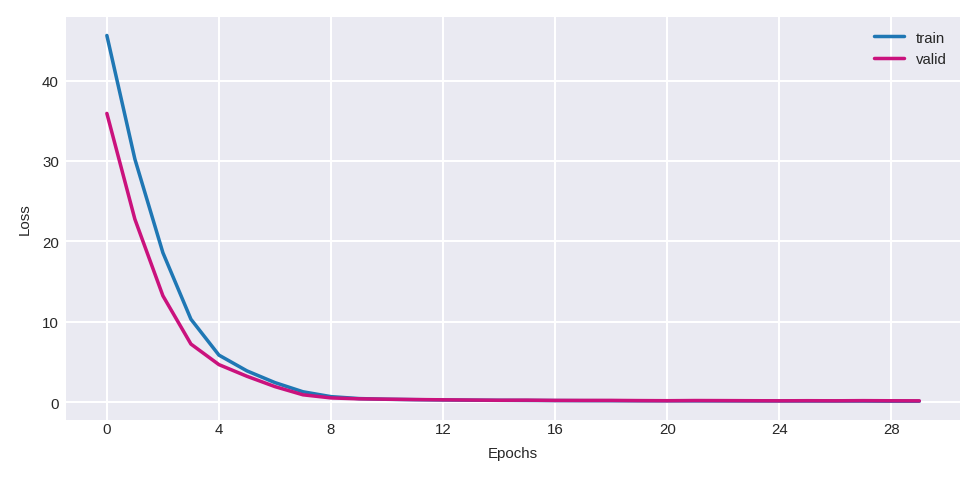

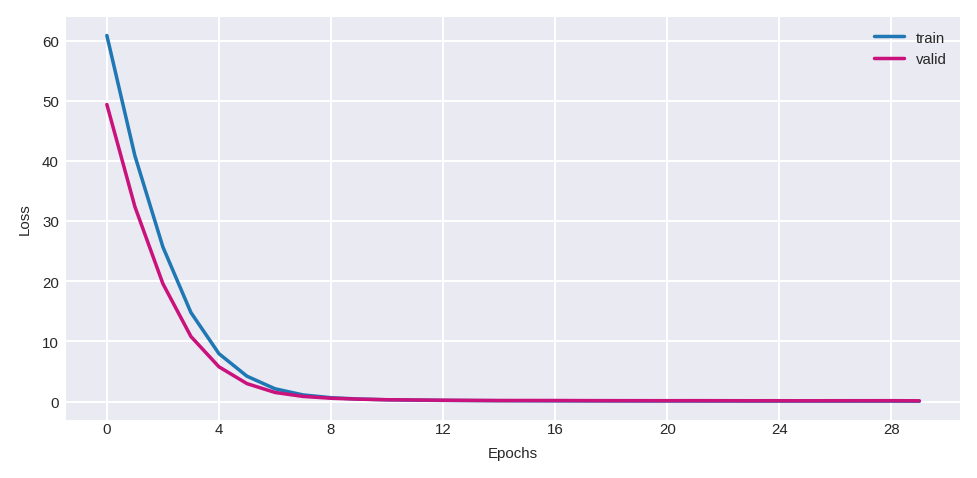

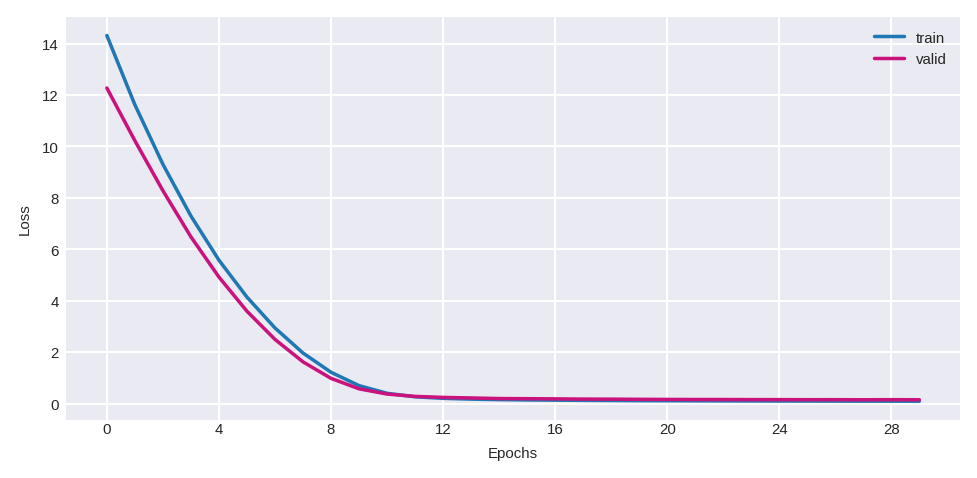

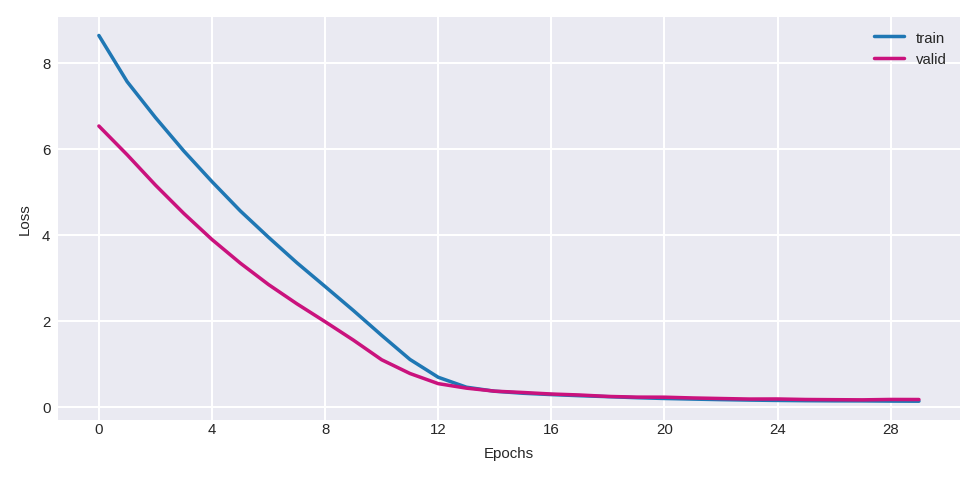

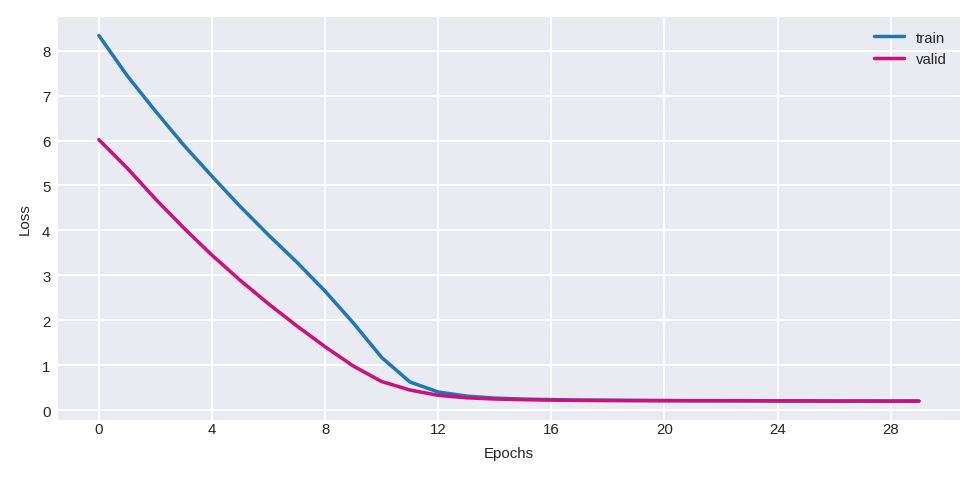

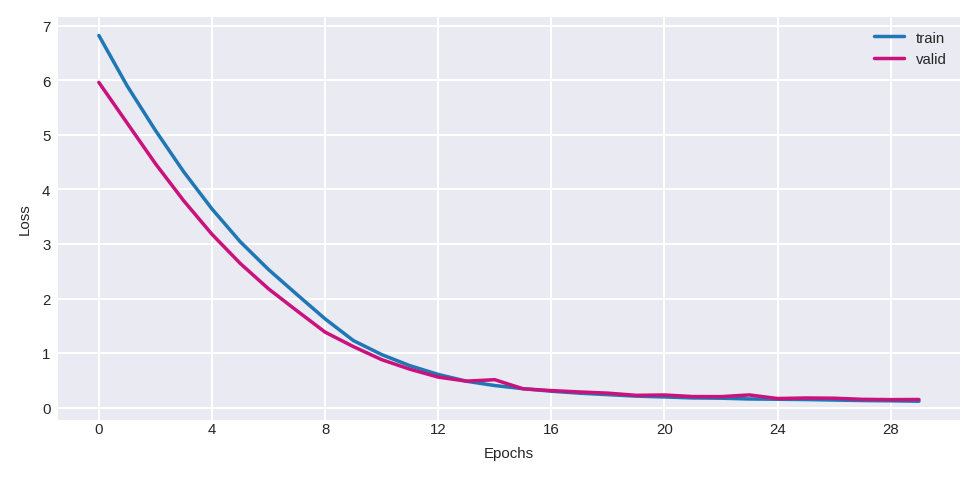

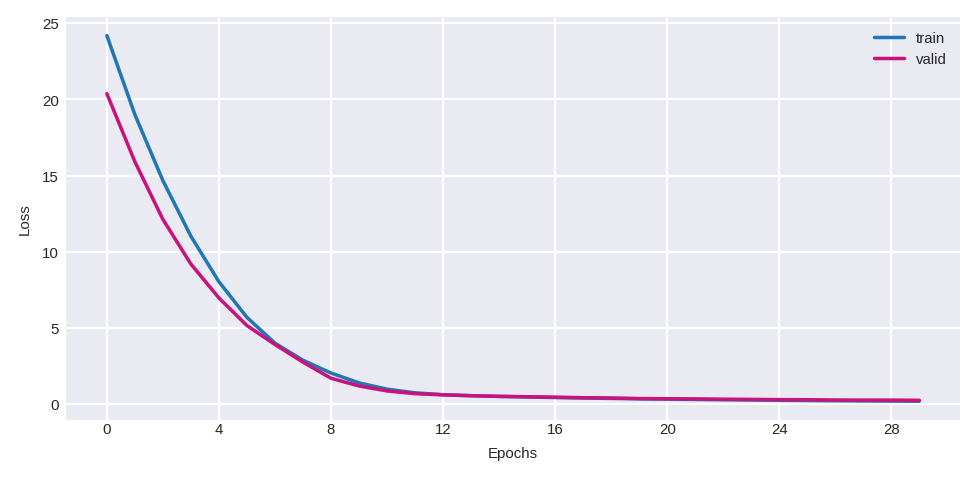

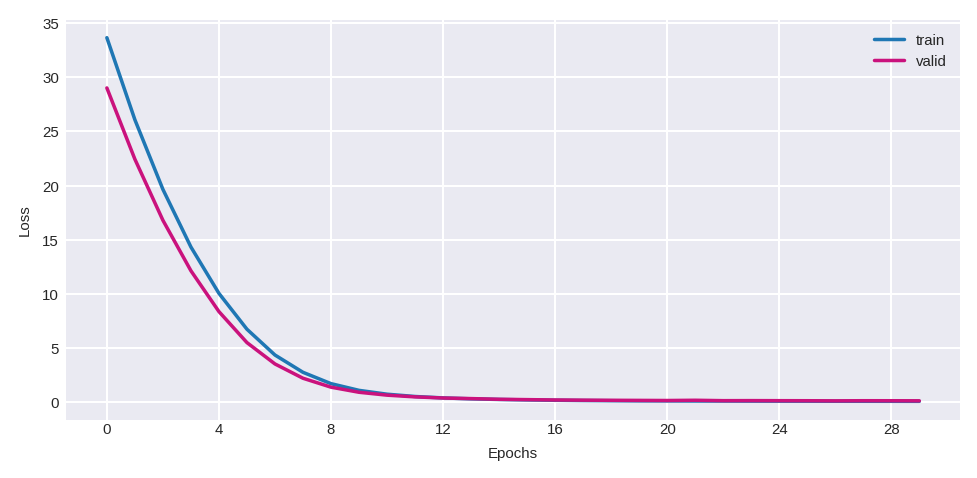

In [9]:
# results_dict={}
for window_size in [2000]: #125, 250, 500, 750, 1000, 1250, 1500, 1750, 
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print(f"Seed was set to: {SEED}")
    
    if str(window_size) not in results_dict:
        results_dict[str(window_size)]={}
        
    P.window_size=window_size
    P.nn_step_width = int(P.window_size * .5)
    P.ocsvm_step_width = int(P.window_size * .5)
    P.scaler = 'RobustScaler'
    
    
    # preparing train data

    # train_set = r
    exp1_df_train_dict, exp2_df_train_dict = {user_key: dfList_exp1[user_key] for user_key in train_set}, {user_key: dfList_exp2[user_key] for user_key in train_set}
    print(f"len(exp1_df_train_dict): {len(exp1_df_train_dict)}")
    print(f"len(exp2_df_train_dict): {len(exp2_df_train_dict)}")
    # Raw_X_Exp_Train_Dict = MakeRawXExpDic(exp1_df_train_dict, exp2_df_train_dict, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
    #                                       scale_exp1=True, scale_exp2=True, scaler=P.scaler)
    # ---- new, realistic way
    Raw_X_Exp_Train_Dict = MakeRawXExpDic(exp1_df_train_dict, exp2_df_train_dict, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]

    # preparing test data
    exp1_df_test_dict, exp2_df_test_dict = {user_key: dfList_exp1[user_key] for user_key in test_set}, {user_key: dfList_exp2[user_key] for user_key in test_set}
    print(f"len(exp1_df_test_dict): {len(exp1_df_test_dict)}")
    print(f"len(exp2_df_test_dict): {len(exp2_df_test_dict)}")
    Raw_X_Exp_Test_Dict = MakeRawXExpDic(exp1_df_test_dict, exp2_df_test_dict, window_size=P.window_size, step=P.ocsvm_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                         scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_ocsvm_exp2_dic = Raw_X_Exp_Test_Dict["fitted_scaler_exp2_dic"]
    Raw_X_exp1_test_dic, Raw_X_exp2_test_dic = Raw_X_Exp_Test_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Test_Dict["Raw_X_exp2_dic"]


    # user 47
    exp1_df_dict_user_47, exp2_df_dict_user_47 = {47: dfList_exp1_user_47[0]}, {47: dfList_exp2_user_47[0]}
    Raw_X_Exp_Train_Dict_user_47 = MakeRawXExpDic(exp1_df_dict_user_47, exp2_df_dict_user_47, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=num_sample_points_per_exp_user_47, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_SNN_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic_user_47, Raw_X_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"]


    user_47_idx = len(P.user_ids)
    print(user_47_idx)
    # if user_47_idx not in train_set:
    #     train_set.append(user_47_idx)
    # print(np.unique(train_set))
    user_47_key = user_47_idx
    Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"][47]
    Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp1_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp1_dic'][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp2_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp2_dic'][47]

    print(Raw_X_Exp_Train_Dict['Raw_X_exp1_dic'].keys())
    print(len(Raw_X_Exp_Train_Dict['Raw_X_exp1_dic'].keys()))

    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]


    spliter = 2*len(Raw_X_exp2_train_dic)//3
    cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[:spliter]}
    cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[:spliter]}
    cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[spliter:]}
    cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[spliter:]}


    # why dont i get equal neg and pos pairs???
    # num_pair_limit_train_2000 = 10348
    # num_pair_limit_valid_2000 = 5614
    # num_pair_limit_train_125 = 8*num_pair_limit_train_2000
    # num_pair_limit_valid_125 = 8*num_pair_limit_valid_2000
    num_samples=28000

    X_train, y_train = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=(2*num_samples)//3)
    X_valid, y_valid = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_samples//3)
    # X_final_train, y_train = prep_X_y_pair(Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, list(Raw_X_exp2_train_dic.keys()), fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_train_2000)

    # 2D Filter Model needs flat 4th dimension
    if P.model_variant == "2d":
        X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
        X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
        X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
        X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

    print(
        f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
        + f" class balance: {np.unique(y_train, return_counts=True)}"
    )
    print(
        f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
        + f" class balance: {np.unique(y_valid, return_counts=True)}"
    )
    data_dict = {}
    data_dict["X_valid"], data_dict["y_valid"], data_dict["X_train"], data_dict["y_train"] = X_valid, y_valid, X_train, y_train


    X_left = np.concatenate([X_train[0], X_valid[0]])
    X_right = np.concatenate([X_train[1], X_valid[1]])
    y_train_valid = np.concatenate([y_train, y_valid])

    X_left, X_right, y_train_valid = sklearn_shuffle(X_left, X_right, y_train_valid, random_state=SEED)

    X_train_valid = [X_left, X_right]


    
    
    
    report_dict={    
        "Training_samples": str(np.unique(y_train, return_counts=True)),
        "Validation_samples": str(np.unique(y_valid, return_counts=True)),
        "smoothing": P.smoothing if P.smoothing!=None else None,
        # "EMA_span": P.span if "EMA" in P.smoothing else None ,
        "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
        "scaler": P.scaler,
    }
    
    for arg_dict_name in cnn_arch_dict:
        if arg_dict_name not in results_dict[str(window_size)]:
            np.random.seed(SEED)
            tf.random.set_seed(SEED)
            print(arg_dict_name)
            arg_dict=cnn_arch_dict[arg_dict_name]

            
            create_model_func = get_create_model_func(P.model_variant, P.window_size, P.feature_cols)

            arg_dict["optimizer_lr"]=0.001
            
            if 1250>window_size>750:
                arg_dict["batch_size"]=256
                arg_dict["optimizer_lr"]=0.001

            elif  1500>=window_size>=1250:
                arg_dict["batch_size"]=128
                arg_dict["optimizer_lr"]=0.001
                
            elif window_size>1500:
                arg_dict["batch_size"]=64
                arg_dict["optimizer_lr"]=0.0001

                
            # arg_dict["optimizer_lr"]=0.0001

            lr_epoch_log_dict={}
            ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 3, "verbose": 1, "min_lr": 1e-6}#change val_loss to eer_val in next iter
            print(arg_dict["optimizer_lr"])
            print(arg_dict)
            loss_record_dict = {'loss': [], 'val_loss': []}
            metric_record_dict = {}
            model = create_model_func(arg_dict)

            # Train
            history = model.fit(
                x=X_train,
                y=y_train,
                batch_size=arg_dict["batch_size"],
                epochs=30,
                verbose=1,
                validation_data=(X_valid, y_valid),
                shuffle=True,
                callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                           loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                           save_plots=True, print_interm_epochs=True, early_stoping=False,
                                          ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
            )
            print(loss_record_dict)
            print("Training History:")
            loss_fig = utils_plot_training_loss(loss_record_dict)

            results_dict[str(window_size)][arg_dict_name]={
                                                    "lr_epoch_log_dict": str(lr_epoch_log_dict),
                                                    "loss_record_dict": loss_record_dict,
                                                    "metric_record_dict": metric_record_dict,
                                                    "report_dict": report_dict,
                                                    "ReduceLROnPlateau_args": ReduceLROnPlateau_args,
                                                    "arg_dict": arg_dict,
            }

            save_results_dict(f"{window_size}-{arg_dict_name}")
            del model
            del history
            K.clear_session()
            tf.compat.v1.reset_default_graph()

In [10]:
1

1

In [11]:
# run with hyperparams you found and compare against default
# in the next run, switch from val_loss to eer_val
remove butter, i dont need we need it
maybe increase the cuttoff for loading dataframse to 5 magnitude
# run on gyr, accel alone

SyntaxError: invalid syntax (2039210648.py, line 3)

In [12]:
del model
del history
K.clear_session()
tf.compat.v1.reset_default_graph()

NameError: name 'model' is not defined

In [ ]:
K.clear_session()
results_dict[str(window_size)].keys()

In [ ]:
# with open("siamese_cnn_results_final/results_dict_1250-SCNN_1_1_conv_1_dense_arg_dict_default20230315-091256.json", 'r') as file:
#     results_dict=json.load(file)
def save_results_dict(desc=''):
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    save_dir = f"siamese_cnn_results_final"
    with open(f"{save_dir}/results_dict_{desc}{dir_name}.json", 'w') as file:
            results_dict_json = json.dumps(results_dict)
            file.write(results_dict_json)
            
            
# save_results_dict()

In [ ]:
lr_pool = np.logspace(-5, -2, num=10)
lr_pool=[1e-5]#, 2e-5]
lr_epoch_log_dict={}
ReduceLROnPlateau_err_mode={}
ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 0, "verbose": 1, "min_lr": 1e-8}
ReduceLROnPlateau_args=ReduceLROnPlateau_args
for lr in lr_pool:
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    arg_dict['optimizer_lr'] = lr
    print(lr)
    print(arg_dict)
    loss_record_dict = {'loss': [], 'val_loss': []}
    metric_record_dict = {}
    model = create_model_func(arg_dict)

    # Train
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=arg_dict["batch_size"],
        epochs=200,
        verbose=1,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                   loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                   save_plots=True, print_interm_epochs=True, early_stoping=False,
                                  ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
    )
    print(loss_record_dict)
    print("Training History:")
    loss_fig = utils_plot_training_loss(loss_record_dict)
    
min_val = min(metric_record_dict['eer_val']["Valid"])
min_val_index=metric_record_dict['eer_val']["Valid"].index(min_val)
print(metric_record_dict['eer_val']["Valid"])
min_val_index

optimal_lr_epoch_dict={}
for i in range(min_val_index+1):
    optimal_lr_epoch_dict[i] = lr_epoch_log_dict[i]
    
optimal_lr_epoch_dict

In [ ]:
2

In [ ]:
SCNN_1_5_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[256, 32, 128, 32, 64]],
    "kernels_streams": [[7, 3, 5, 3, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
    "strides_streams": [[1, 1, 1, 1, 1]],
    "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
    "dropouts_streams": [[0.5, 0.4, 0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_simple_1_5_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 16, 32, 8, 16]],
    "kernels_streams": [[7, 3, 5, 3, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1", "l2", "l1", "l2", "l1"]],
    "strides_streams": [[1, 1, 1, 1, 1]],
    "paddings_streams": [["causal", "causal", "causal", "causal", "causal"]],
    "dropouts_streams": [[0.1, 0.1, 0.1, 0.1, 0.1]],
    "activations_streams": [['relu', 'relu', 'relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_3_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
                             ["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"],["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.2], [.2], [.2]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
}

SCNN_4_1234_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2, .2], #5**3
    "filters_streams": [[16], [16, 32], [16, 32, 64], [16, 32, 64, 128]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3], [9, 7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"],
                            ["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3], [3, 3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"], ["l2", "l1", "l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1], [1, 1, 1, 1]], #4**3
    "paddings_streams": [["causal"], ["causal", "causal"], ["causal", "causal", "causal"], ["causal", "causal", "causal", "causal"]], #2*3
    "dropouts_streams": [[.2], [.2, .3], [.2, .3, .4], [.2, .3, .4, .5]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_3_123_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [128, 64], [256, 128, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}


SCNN_1_3_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[256, 128, 64]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64, 32]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,
    

}

SCNN_1_1_conv_1_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64]],
    "kernels_streams": [[3]],
    "kernels_init_streams": [["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3]],
    "strides_streams": [[1]],
    "conv_kernel_regularizer_streams": [["l1"]],
    "paddings_streams": [["same"]],
    "dropouts_streams": [[0.2]],
    "activations_streams": [['relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,

}

SCNN_1_2_conv_2_dense_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[128, 64]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.3]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [32, 84],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l1", "l2"],
    "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
    "dense_dropouts": [0.2, 0.2], 
    "dense_activations": ['relu', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-2,
    "optimizer_decay": None,
    
    "batch_size": 512,


}


# single_head_8layercnn_2layerdense_SCNN_arg_dict_default = {
#     "input_dropout_streams": [0.2],
#     "filters_streams": [[32, 32, 64, 64, 128, 128, 256, 256]],
#     "kernels_streams": [[3, 3, 5, 5, 7, 7, 9, 9]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_Max_Norm_constraint_streams": [[3, 3, 3, 3, 3, 3, 3, 3]],
#     "strides_streams": [[15, 1, 1, 1, 1, 1, 1, 1]],
#     "paddings_streams": [["same", "same", "same", "same", "same", "same", "same", "same"]],
#     "dropouts_streams": [[0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5]],
#     "activations_streams": [['swish', 'swish', 'swish', 'swish', 'swish', 'swish', 'swish', 'swish']],
    
#     "dense_layers": [128, 256],
#     "dense_kernel_Max_Norm_constraints": [3, 3],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ['swish', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 3e-4,
#     "optimizer_decay": None,
    
#     "batch_size": 32,
    
    
#     "Training_samples": str(np.unique(y_train, return_counts=True)),
#     "Validation_samples": str(np.unique(y_valid, return_counts=True)),

# }

# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32, 32, 32]],
#     "kernels_streams": [[3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"]],
#     "dropouts_streams": [[0.1, 0.1, 0]],
#     "activations_streams": [['relu', 'relu', 'relu']],
    
#     "dense_layers": [128],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32, 32]],
#     "kernels_streams": [[3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1]],
#     "paddings_streams": [["same", "same"]],
#     "dropouts_streams": [[0.1, 0]],
#     "activations_streams": [['relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }


# arg_dict_default = {
#     "input_dropout_streams": [0],
#     "filters_streams": [[32]],
#     "kernels_streams": [[3]],
#     "kernels_init_streams": [["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)]],
#     "strides_streams": [[1]],
#     "paddings_streams": [["same"]],
#     "dropouts_streams": [[0.1]],
#     "activations_streams": [['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[7, 7, 7], [5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32], [32, 32], [32, 32]],
#     "kernels_streams": [[7, 7], [5, 5], [3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1], [1, 1], [1, 1]],
#     "paddings_streams": [["same", "same"], ["same", "same"], ["same", "same"]],
#     "dropouts_streams": [[.1, .1], [.1, .1], [0.1, .1]],
#     "activations_streams": [['relu', 'relu'], ['relu', 'relu'], ['relu', 'relu']],
    
#     "dense_layers": [32],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)], [MaxNorm(3)], [MaxNorm(3)]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":[MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }


# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }


# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }

# arg_dict = {
#     "input_dropout_streams": [.2, .2, .2], #5**3
#     "filters_streams": [[32], [32], [32]], #6**3
#     "kernels_streams": [[7], [5], [3]], #4*3
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [["MaxNorm(3)"], ["MaxNorm(3)"], ["MaxNorm(3)"]], #3**3
#     "strides_streams": [[1], [1], [1]], #4**3
#     "paddings_streams": [["same"], ["same"], ["same"]], #2*3
#     "dropouts_streams": [[.1], [.1], [.1]], #5**3
#     "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
#     "dense_layers": [84],
#     "dense_kernel_constraints":["MaxNorm(3)"],
#     "dense_kernel_inits": ["glorot_uniform"],
#     "dense_dropouts": [0], 
#     "dense_activations": ["sigmoid"],
    
#     "loss_func": "k_contrastive_loss",
#     "optimizer": "Adam",
# }

# arg_dict_default = {
#     "input_dropout_streams": [0, 0, 0],
#     "filters_streams": [[32, 32, 32], [32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[7, 7, 7], [5, 5, 5], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [.1, .1, .1], [0.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [],
#     "dense_kernel_constraints":[],
#     "dense_kernel_inits": [],
#     "dense_dropouts": [], 
#     "dense_activations": [],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0.2, 0.2, 0.2],
#     "filters_streams": [[32], [32], [32]],
#     "kernels_streams": [[7], [5], [3]],
#     "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], 
#                              ["glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3)], [MaxNorm(3)], [MaxNorm(3)]],
#     "strides_streams": [[1], [1], [1]],
#     "paddings_streams": [["same"], ["same"], ["same"]],
#     "dropouts_streams": [[.1], [.1], [0.1]],
#     "activations_streams": [['relu'], ['relu'], ['relu']],
    
#     "dense_layers": [84, 84],
#     "dense_kernel_constraints":[MaxNorm(3), MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.1, 0.1], 
#     "dense_activations": ['relu', "sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }

# arg_dict_default = {
#     "input_dropout_streams": [0.2, 0.2, 0.2],
#     "filters_streams": [[10, 20, 30], [10, 20, 30], [10, 20, 30]],
#     "kernels_streams": [[8, 5, 3], [5, 5, 3], [3, 3, 3]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"], 
#                              ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.2, .3, .4], [.2, .3, .4], [0.2, .3, .4]],
#     "activations_streams": [['tanh', 'tanh', 'tanh'], ['tanh', 'tanh', 'tanh'], ['tanh', 'tanh', 'tanh']],
    
#     "dense_layers": [32, 64],
#     "dense_kernel_constraints":[MaxNorm(3), MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.4, 0.5], 
#     "dense_activations": ['tanh', "sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": optimizer,
# }
